<a href="https://colab.research.google.com/github/sushmitamuz002/Rossmann_Sales_Prediction_Capstone_Project-ML_Regression-/blob/main/Rossmann_Sales_Prediction_Capstone_Project_(ML_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# installing required library
%pip install inflection
%pip install Boruta

     |████████████████████████████████| 56 kB 3.3 MB/s 


##**Importing Libraries**

In [ ]:
# importing libary that are required in the porject
import math
import json
import pylab
import pickle
import random
import requests
import datetime
import warnings
import inflection # used when renaming columns in subsection 1.1

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs

from scipy                 import stats as ss
from boruta                import BorutaPy
from tabulate              import tabulate

from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

###**0.1 Helper Functions**
Here there are some functions that will be helpful in the project

In [ ]:
# Here there are some functions that will be helpful in the project
# time series cross valdiation fuction that will be used in step 7 to find the best ML model
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    # creating empty lists to store te error results
    mae_list = []
    mape_list = []
    rmse_list = []
   
    # iterating over a range for the k fold
    for k in reversed (range( 1, kfold+1 ) ):
        if verbose:
            print( f'\nKFold Number: {k}' )
        # getting the start and the end dates for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )
        
        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[x_training['date'] >= validation_end_date]
        
        # creating the training and validation datasets
        # training
        xtraining = training.drop( ['date', 'sales'], axis = 1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis = 1 )
        yvalidation = validation['sales']
        
        # setting the model
        m = model.fit( xtraining, ytraining) # it uses the model passed in the function
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ))
        
        # storing performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
       
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


# function to perform a correlation coeficient with categorical variables. it'll be used in section 4: EDA.
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    #correcting cramer's V bias
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# creating the mean absolute percentage error
def mean_percentage_error( y, y_hat ):
    return np.mean( ( y - y_hat ) / y )

# creating the mean absolute percentage error
def mean_absolute_percentage_error( y, y_hat ):
    return np.mean( np.abs( ( y - y_hat ) / y ) )

# creating a function to calculate the model error
def ml_error( model_name, y, y_hat ):
    mae = mean_absolute_error( y, y_hat )
    mape = mean_absolute_percentage_error( y, y_hat )
    rmse = np.sqrt( mean_squared_error( y, y_hat ) )
    
    
    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index = [0])

# setting some notebook display as default
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# diplay format(float type)
pd.set_option( 'display.float_format', lambda x: '%.2f' % x )

# setting plot parameters as default
plt.rcParams[ 'figure.figsize' ] = [20, 7]
plt.rcParams[ 'font.size' ] = 24
sns.set_style( "white" )

###**0.2. Loading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the dataset
df_Rstore = pd.read_csv("/content/drive/MyDrive/Datasets/Rossmann Stores Data.csv")
df_store = pd.read_csv("/content/drive/MyDrive/Datasets/store.csv")

In [ ]:
# Merging both the dataset on store columnn because it present on both the dataset
df_raw = pd.merge(df_Rstore,df_store , on = 'Store', how='left' )

##**1.0. STEP 1: DATA DESCRIPTION**

In [ ]:
df1 = df_raw.copy()

###**1.1. Rename Columns**
We basically rename them to better manipulate and visualize the data, since the names become shortly and intuitive after renaming

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# creating new names with a snakecase pattern
snakecase = lambda x: inflection.underscore( x )

# creating a list containing the new column names
cols_new = list(map(snakecase, cols_old))

# renaming the dataframe columns
df1.columns = cols_new

###**1.2. Data Dimensions**

In [ ]:
# checking the dimension of data
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


###**1.3. Data Types**

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] ) # changing 'date' column from object to pandas datetime
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

###**1.4. Checking for NANs**

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

###**1.5. Filling out NANs**
**competition_distance:**

I'll assume that if the value is missing it's because there'no competitor close to the store. Thus if I input a distance greater than the maximum distance of the column it's the same as there'no competitor close.

The maximum distance is 75,860m. So, if the value is missing, I will input 200,000m

In [ ]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

**competition_open_since_month and competition_open_since_year:**

There can be two reasons for missing values in this column:

the store doesn't really have a close competitor.
The store does have a close competitor, but we don't know when it was opened. Maybe the competitor existed before or after the store opening.
So, what I'll do: if the store has a NA in this column, I'll copy the date from this line to the competition_since_month. The main reason to do it is because I believe that this column is important to the model.

For now, it's not a big problem because I'm working in cycles. Thus, if this assumption doesn't help in the modeling performance, I handle it in the next CRISP cycle.

In [ ]:
# competition_open_since_month
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace=True )

In [ ]:
# competition_open_since_year
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace=True )

####**promo2_since_week and promo2_since_year:**

If there are missing values in these columns, maybe it's because the store is not participating in promo2. So, we'll fill it out with the present date.

In [ ]:
# promo2_since_week
df1['promo2_since_week'].fillna( df1['date'].dt.isocalendar().week, inplace=True )
# promo2_since_year
df1['promo2_since_year'].fillna( df1['date'].dt.year, inplace=True )

####**promo_interval:**

I'm going to create the column is_promo (dummy variable) to indicate whether a store is holding consecutive promo sales on that day and the promo_interval will be dropped in Step 3.

In [ ]:
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna('', inplace=True) 

# getting month abreviation
df1['month_map'] = df1['date'].dt.strftime( "%b" ) 

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')


###**1.6. Change Data Types**
Some features has float as type but they should be integer. So, they're going to be changed.

In [ ]:
# changing the float type to integer type
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )

###**1.7. Descriptive Statistics**
This subsection provides both a business notion (with metrics of dispersion and central tendency) and a detection of error in the data

In [ ]:
# dividing data in numerical and categorical
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

###**1.7.1. Numerical Attributes**

In [ ]:
# Central Tendendy - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# concatenating them and printing
m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
m

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,store,1.00,1115.00,1114.00,280.00,558.00,838.00,558.43,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,2.00,4.00,6.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,3727.00,5744.00,7856.00,5773.82,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,405.00,609.00,837.00,633.15,464.41,1.60,7.09
4,open,0.00,1.00,1.00,1.00,1.00,1.00,0.83,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.00,0.00,1.00,0.38,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.00,0.00,0.00,0.18,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,710.00,2330.00,6910.00,5935.44,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,4.00,7.00,10.00,6.79,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2008.00,2012.00,2014.00,2010.32,5.52,-7.24,124.07


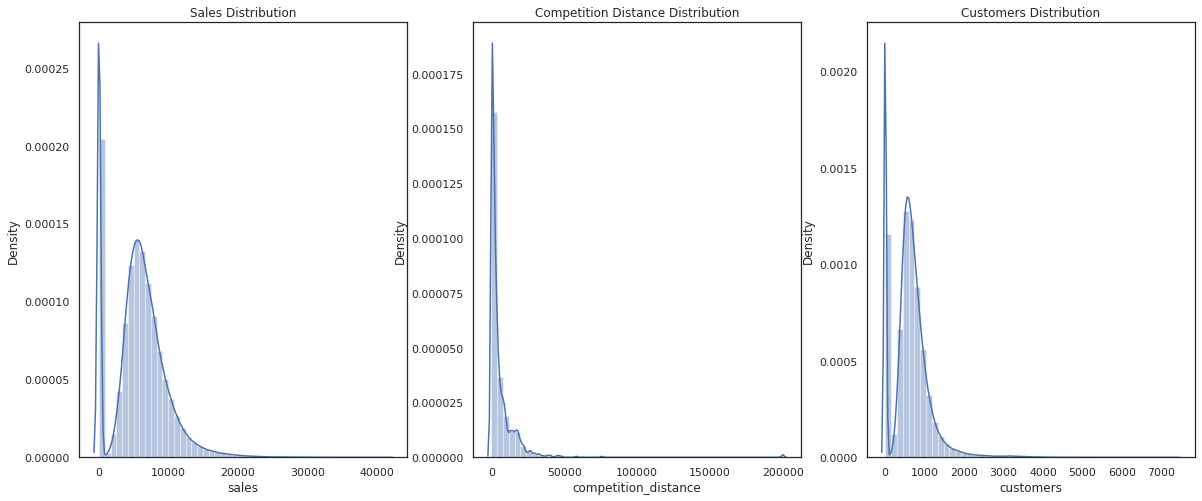

In [ ]:
# plotting distribution plots for finding the central tendency
plt.figure(figsize=(20, 8))

plt.subplot( 1,3,1)
sns.distplot( df1['sales'] )
plt.title( 'Sales Distribution' )

plt.subplot( 1,3,2 )
sns.distplot( df1['competition_distance'] )
plt.title( 'Competition Distance Distribution' );

plt.subplot( 1,3,3 )
sns.distplot( df1['customers'] )
plt.title( 'Customers Distribution' );

In EDA Section I'll check if sales distribution is or not normal.

###**1.7.2. Categorical Attributes**

In [ ]:
# taking a first look at the levels of each categorical variables
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

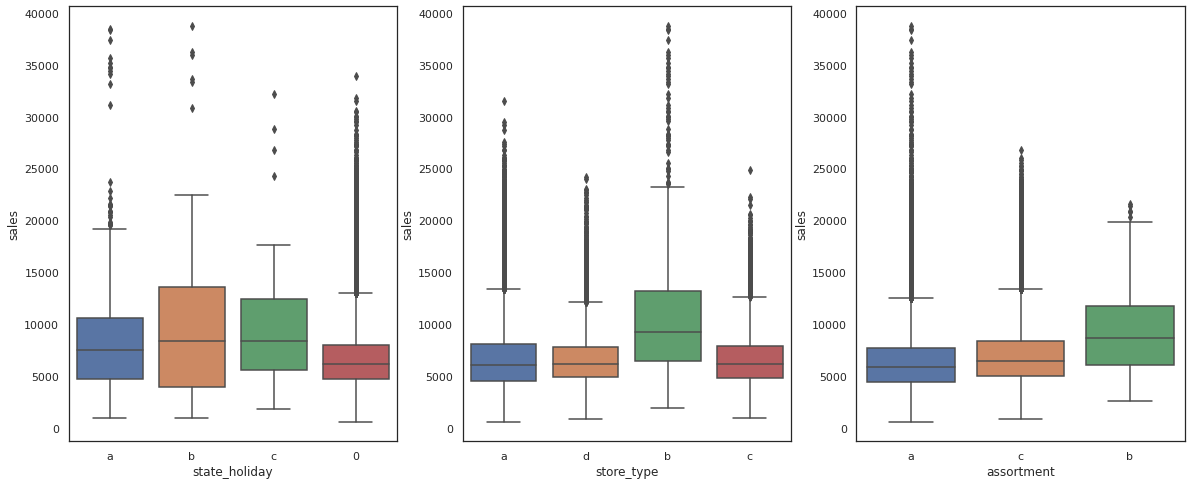

In [ ]:
# plotting box plot for categorical variables
plt.figure(figsize=(20,8))
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y ='sales', data = aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y ='sales', data = aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux );

##**2.0. STEP 2: FEATURE ENGINEERING**

In [ ]:
df2 = df1.copy()

####**2.1. Hypothesis Mind Map**
To better understand the relationship between the target variable (sales) and the features, I'll create some hypothesis based on the business problem to guide the feature engineering and then the exploratory data analysis.

In the EDA section, I'll validate these hypothesis and it'll let me have a good notion about the relation between the features and the target and it will help me to choose more accurately what feature to use when modeling.

However, before I do that, a mind map can be useful when creating all the hypothesis.

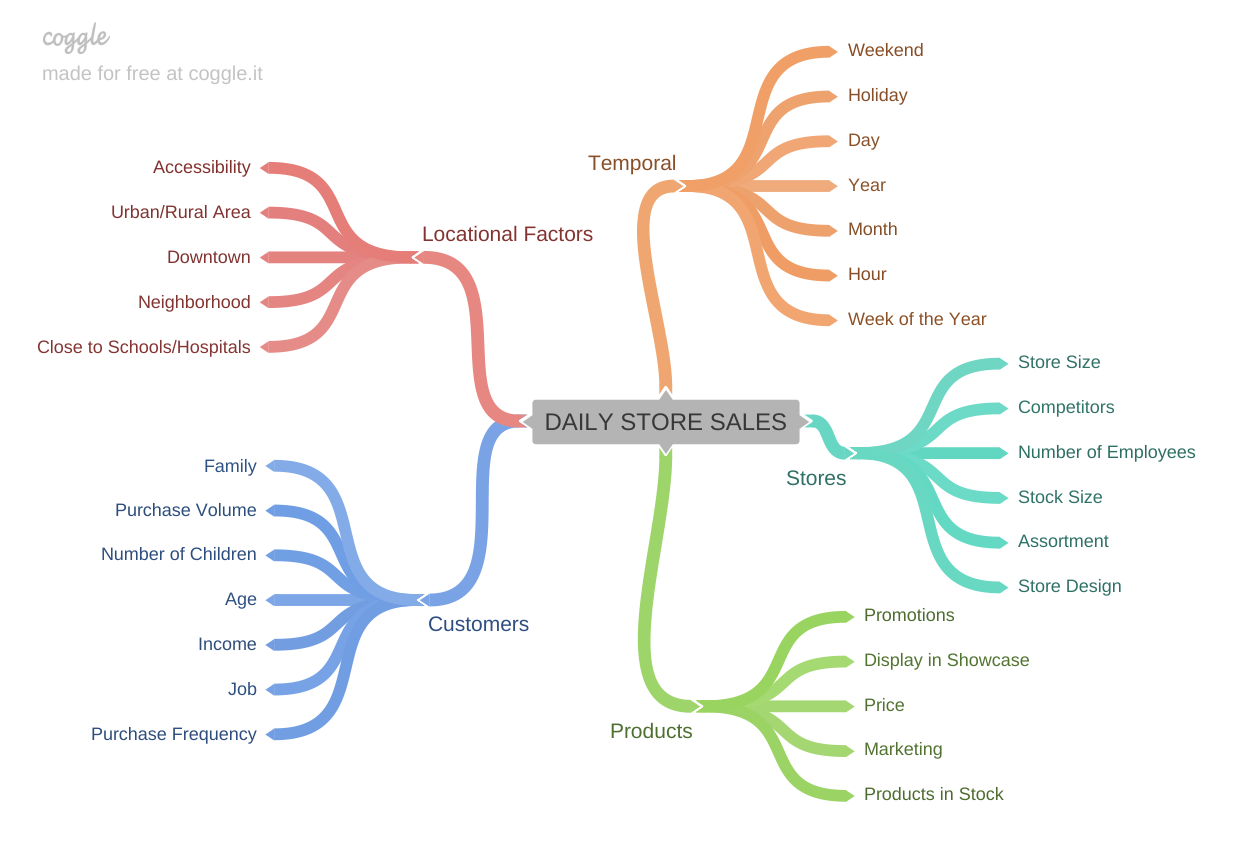

###**2.2. Hypothesis Creation**
####**2.1.1. Store Hypothesis**
1. Stores with more employees should sell more.

2. Stores with greater stock capacity should sell more.

3. Larger stores should sell more.

4. Stores with a larger assortment should sell more.

5. Stores with closer competitors should sell less.

6. Stores with longer competitors should sell more

####**2.1.1. Product Hypothesis**
1. Stores that invest more in Marketing should sell more.

2. Stores with greater product exposure should sell more.

3. Stores with lower priced products should sell more.

5. Stores with more aggressive promotions (bigger discounts) should sell more.

6. Stores with active promotions for longer should sell more.

7. Stores with more promotion days should sell more.

8. Stores with more consecutive promotions should sell more.

####**2.1.1. Temporal Hypothesis**
1. Stores open during the Christmas holiday should sell more.

2. Stores should be selling more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less on weekends.

6. Stores should sell less during school holidays.

####**2.3. Hypothesis Final List**
The next step is to choose which of them will be considered in the EDA section. The criterion I'll use is the availability of the corresponding feature. For instance, there's no data for number of employees or stock size, so, their corresponding hypothesis will not be considered.

This, the following hypothesis final list is created.

1. Stores with a larger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more

4. Stores with active promotions for longer should sell more.

5. Stores with more promotion days should sell more.

6. Stores with more consecutive promotions should sell more.

7. Stores open during the Christmas holiday should sell more.

8. Stores should be selling more over the years.

9. Stores should sell more in the second half of the year.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

###**2.4. Feature Engineering**
Now it's time to create some new features. It'll basically follow the needs of the list of hypothesis.

Year, month, day, week of year and year week

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype( int )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

####**competition since and promo since**

There are two columns related to competition. I'll make them only one date and then subract from the sale's date. It's the basically the same for promo since

In [ ]:
# competition_since: how long the competition exists considering the purchase date
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int ) # to get month

In [ ]:
# promo_since: how long is there an active promotion
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

assortment and state holiday

In [ ]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular')

Since store type has no description in the data source, I wont change it.

##**3.0. STEP 3: FILTERING VARIABLES**

In [ ]:
df3 = df2.copy()

Based on business restrictions (e.g. we won't have a variable avaliable in the future to use in the prediciton), we have to properly filter variables.

###**3.1. Row Filtering**
open: it's kind of obvious that closed stores has no sales in that day. Thus, this column also won't be used.

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###**3.2. Columns Selection**
customers: I can't use customers because I won't have this data for the next six weeks (the prediction period) unless I build another project to predict how many customers the stores will have in that period. Since this is not the case, I'll drop it.

promo_interval and month_map were used to create new columns. They'll not be used anymore.

In [ ]:
# dropping the columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )

##**4.0. STEP 4: EXPLORATORY DATA ANALYSIS**


**The main goal of this section:**
*  what variables have a strong relationship with the target and how much is that relation. 
* Based on this relationship, I can better decide what features to use to predict sales.

In [ ]:
df4 = df3.copy()

In [ ]:
# dividing data in numerical and categorical
num_attributes = df4.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df4.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

###**4.1. Univariate Analysis**

####**4.1.1. Response Analysis**

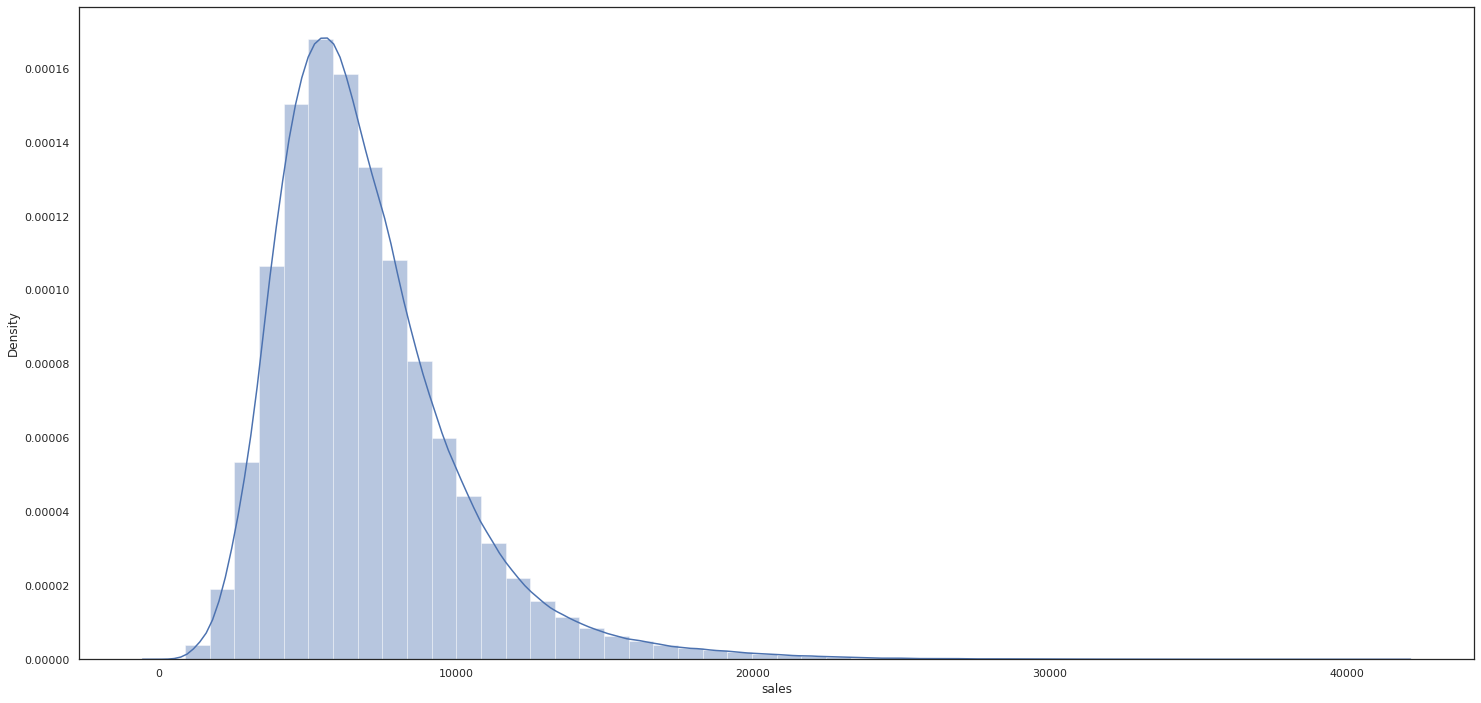

In [ ]:
sns.distplot( df4['sales'] );

Some ML algorithms needs the data to be normal. Let's check if the sales distribution is normal. First, let's look at a q-q plot and then at a Shapiro-Wilk test for normality.

As show in the plot bellow, sales distribution don't seem to be normal

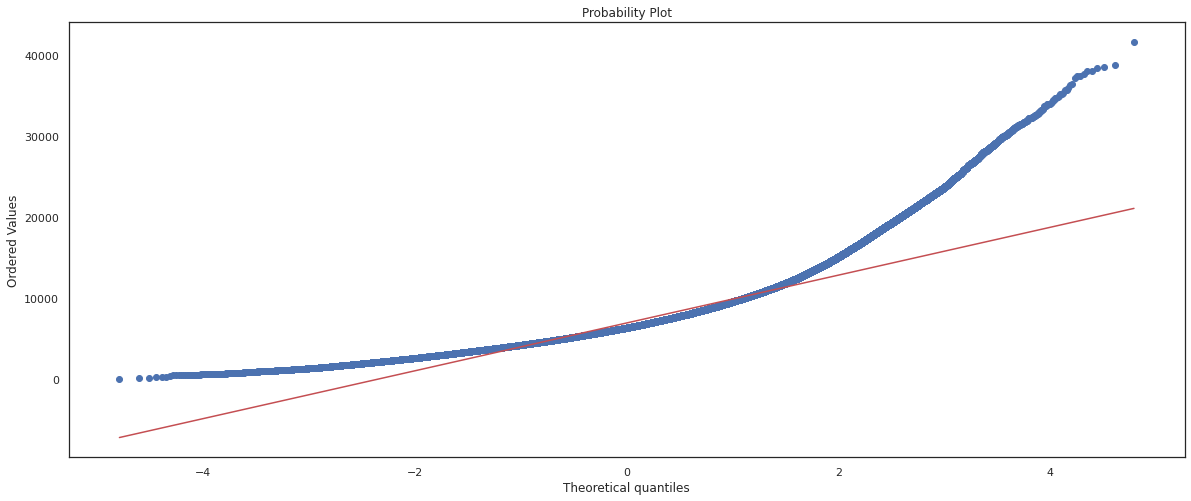

In [ ]:
#sales = df4[df4['sales'] != 0]['sales']
plt.figure(figsize=(20,8))
ss.probplot( df4['sales'], dist = 'norm', plot = pylab );

In [ ]:
# Shapiro-Wilk test for normality
stat, p = ss.shapiro( df4['sales'] )
print('Shapiro-Wilk test for normality: \n')
print( 'stat=%.3f, p=%.3f\n' % ( stat, p ) )
if p > 0.05:
    print( 'It\'s Probably Gaussian' )
else:
    print( 'It\'s Probably non Gaussian' )

Shapiro-Wilk test for normality: 

stat=0.902, p=0.000

It's Probably non Gaussian


####**Conclusions:**

Sales distribution is not normal. Thus, I'll have to change it later for a better prediction performance

###**4.1.2. Numerical Variables**


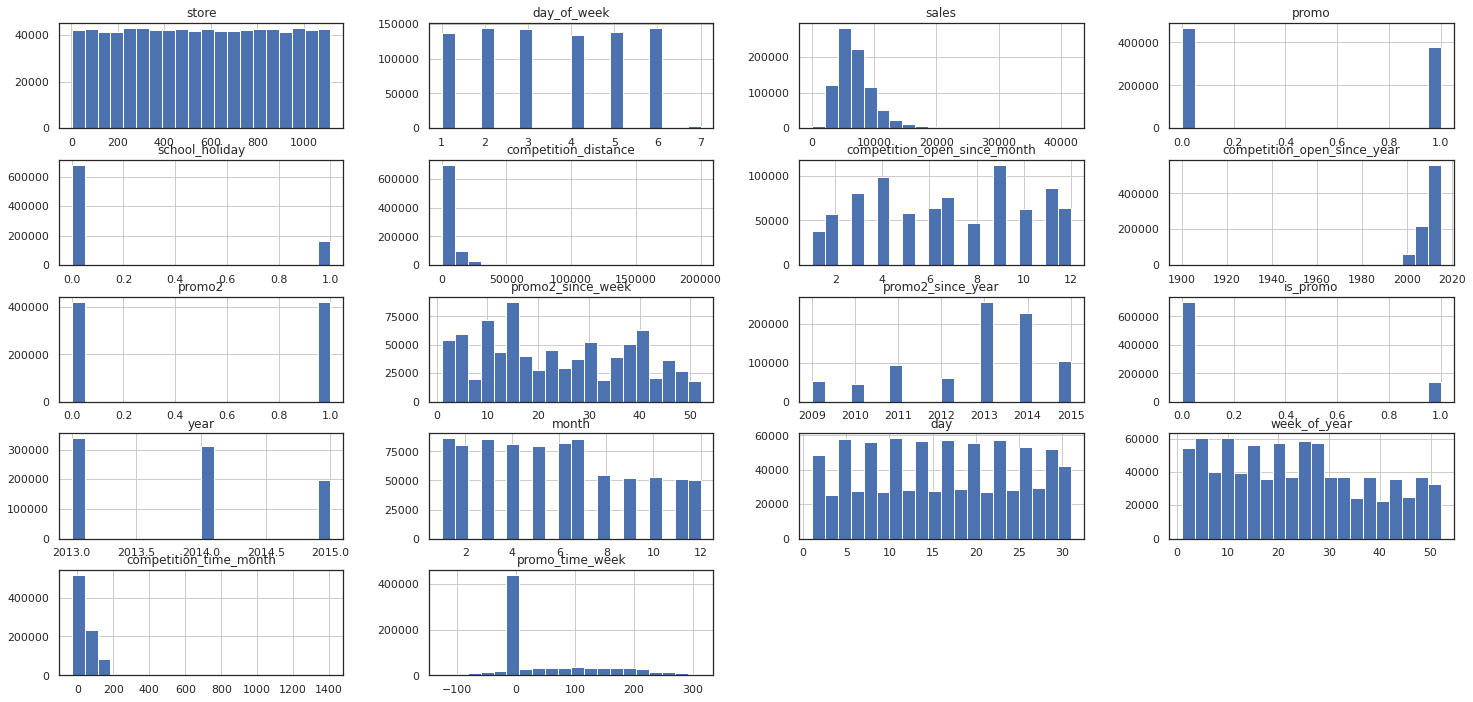

In [ ]:
num_attributes.hist( bins = 20 );

####**Some Conclusions:**

it seems that there are more competitores close than far and the are more new competitors;
day_of_week, if analysed on its own, doesn't seem to have any kind of pattern;

###**4.1.3. Categorical Analysis**

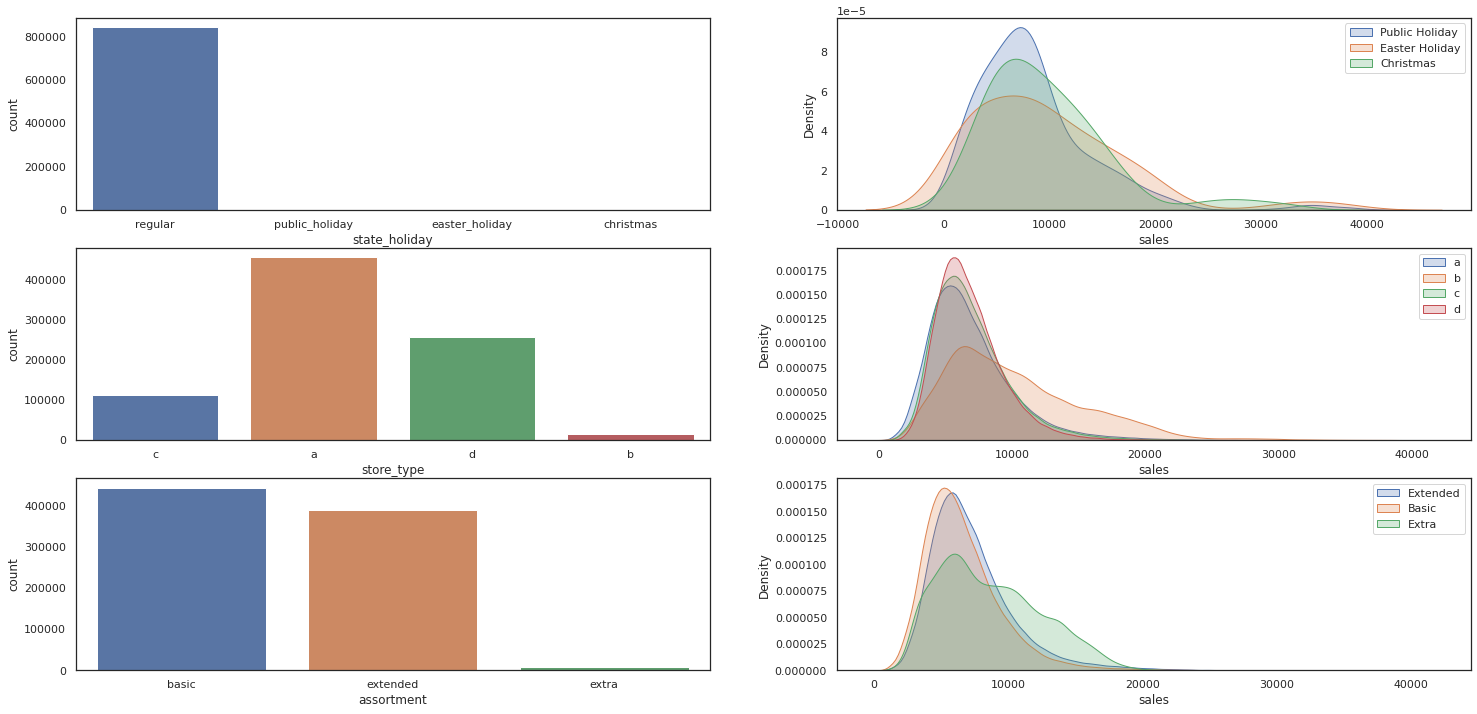

In [ ]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True )
plt.legend();

####**Conclusions:**

There's a difference for the three types of state holiday. Based on that difference, the model could better adjust its predictions;

For different type of stores, sales have a different behavior. For instance, store of type b have sales less concentrated than the others;

there's no much difference between assortments extended and basic, but it's clear that they are different than Extra.

In sum, all these three features are considered important to the model since they can bring information about the target variable.

###**4.2. Bivariate Analysis - Hypothesis Validation**
Now, it's time to see if those hypothesis I made are true or false. 

To do that, they'll be validated one by one.

**In sum I'll basically do:**

validate the hypothesis;

conclude if the feature is important to use in the model.

**H1. Stores with a larger assortment should sell more.**

False: On average, sales seem to increase as the assortment is bigger. Also,

analysing over the weeks, we can see that 'extended' and 'basic' moves quite

similar.

In [ ]:
# counting values for each class in assortment
for index,value in zip(df4['assortment'].value_counts().index, df4['assortment'].value_counts()):
    print(index,value)

basic 444875
extended 391254
extra 8209


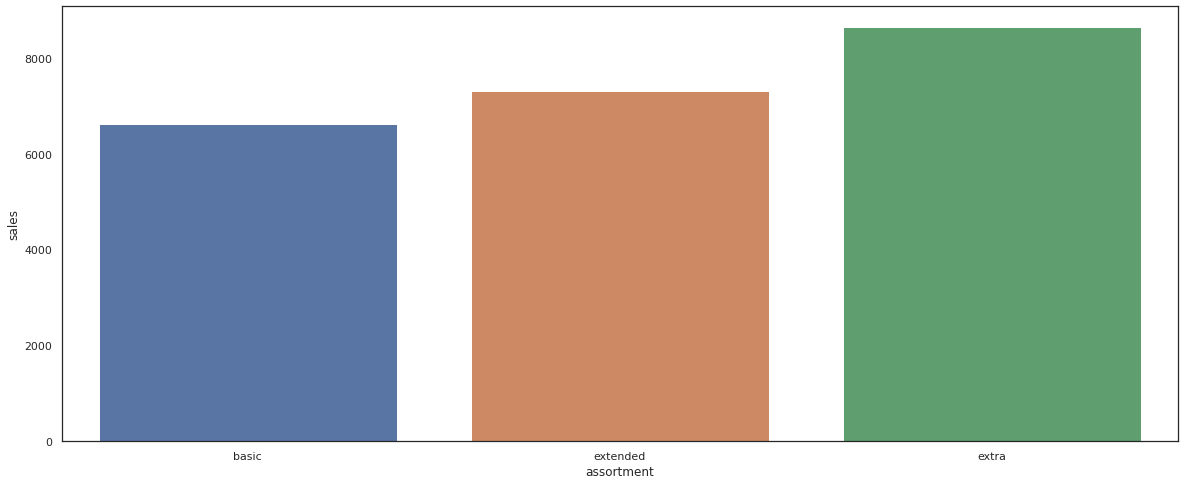

<Figure size 1440x360 with 0 Axes>

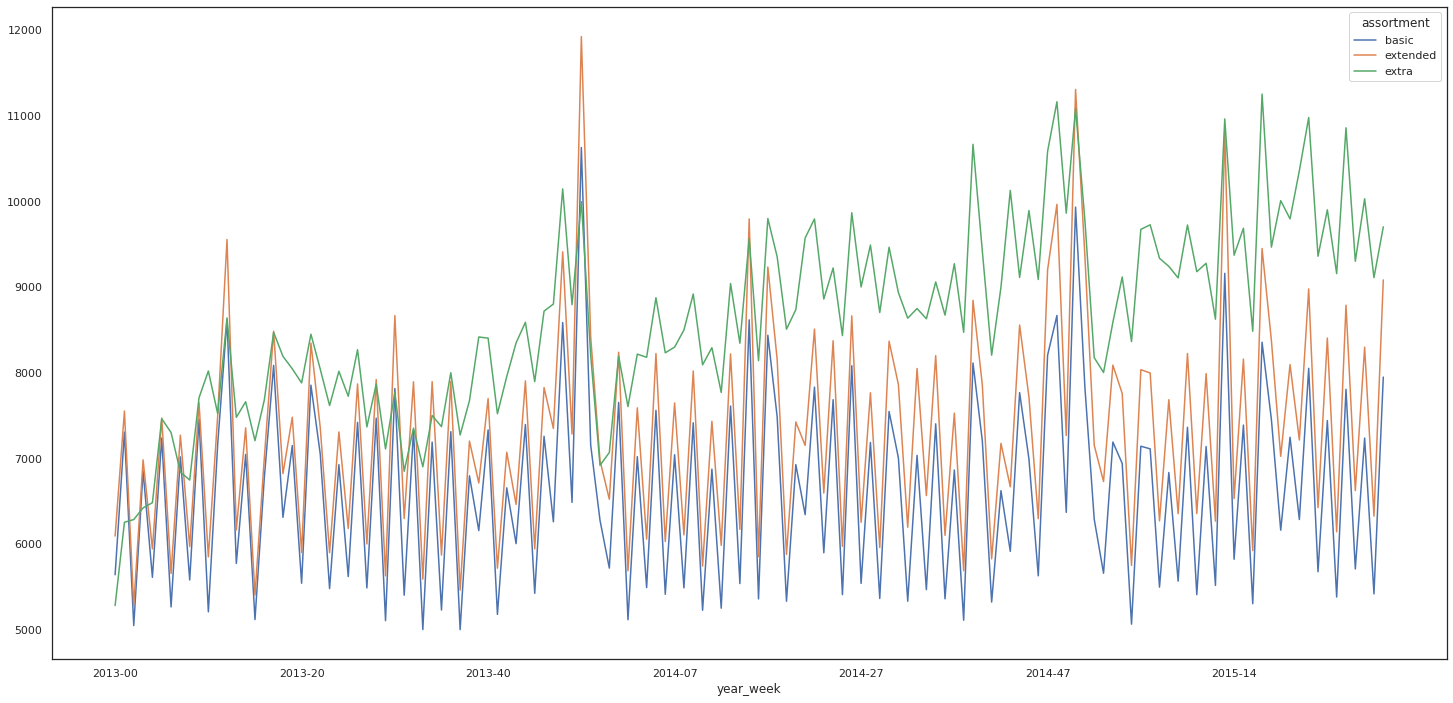

In [ ]:
from IPython.core.pylabtools import figsize
plt.figure(figsize=(20,8))
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data = aux1 )
plt.show()
plt.figure(figsize=(20,5))
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();
plt.show()

####**H2. Stores with closer competitors should sell less.**
**False**: stores with closer competitors sell more. Competition distance and sales have a negative non linear correlaiton, which means that as the distance increases, sales decrease. That correlation (-0.23) is good enough to consider the variable important to the model.

I'll create groups for competition_distance to better visualize.

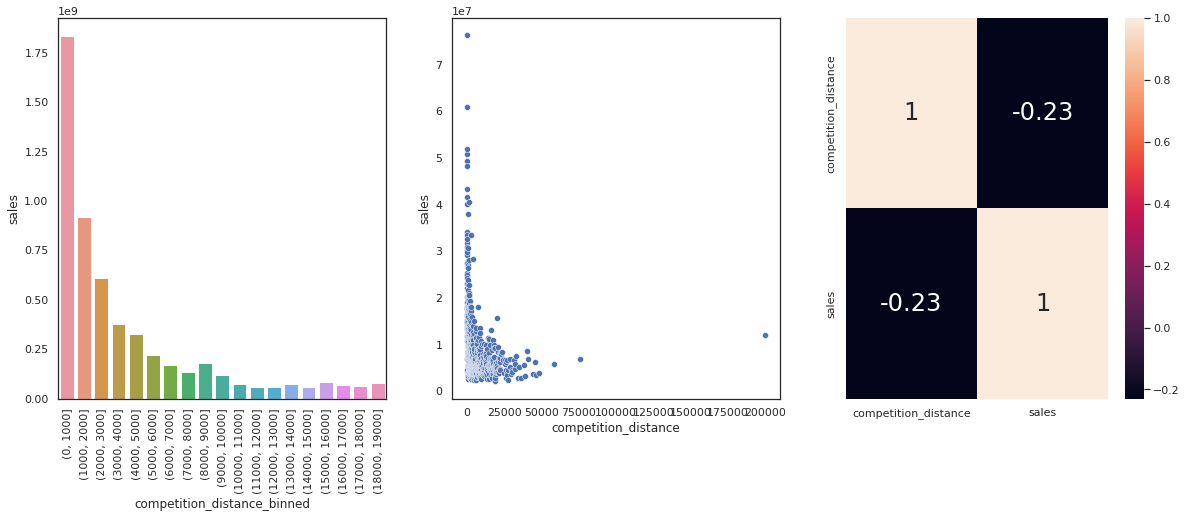

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# creating bins to group the data by bins to better visualize
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
plt.figure(figsize=(20,7))

plt.subplot( 1, 3, 1 )
sns.barplot( x='competition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

plt.subplot( 1, 3, 2 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );

####**H3. Stores with longer competitors should sell more**
**False**: the more recent the competition, the higher the sale. The feature is relevant to the model because its correlation with the target is not to close too zero.

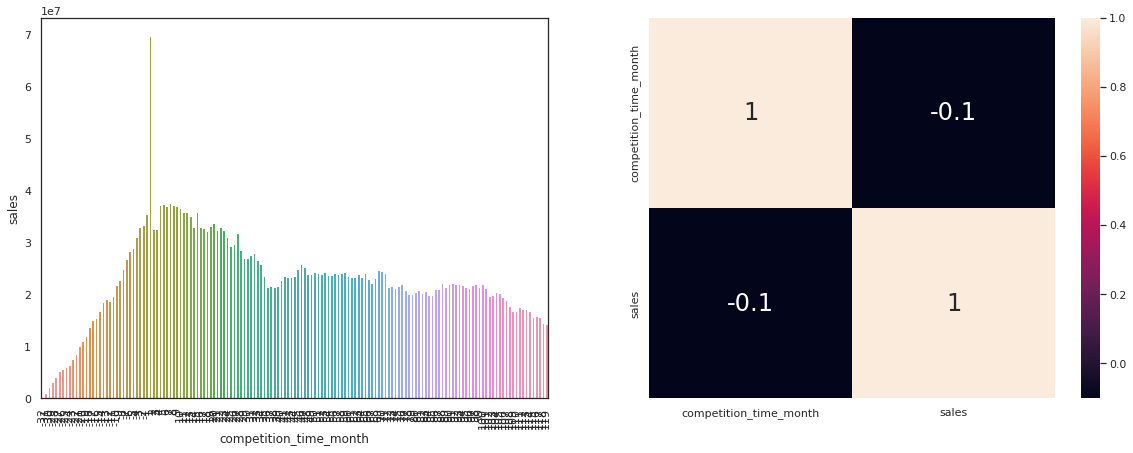

In [ ]:
aux1 = df4[ ['competition_time_month', 'sales'] ].groupby( 'competition_time_month' ).sum().reset_index()
plt.figure(figsize=(20,7))
plt.subplot( 1, 2, 1 )
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot( x='competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );

####**H4. Stores with active promotions for longer should sell more.**
**False**: stores with active promotions for longer sell less because sales starts to decrease after a period of time. According to the correlation, there's no evidence of a strong relationship between this feature and the target.

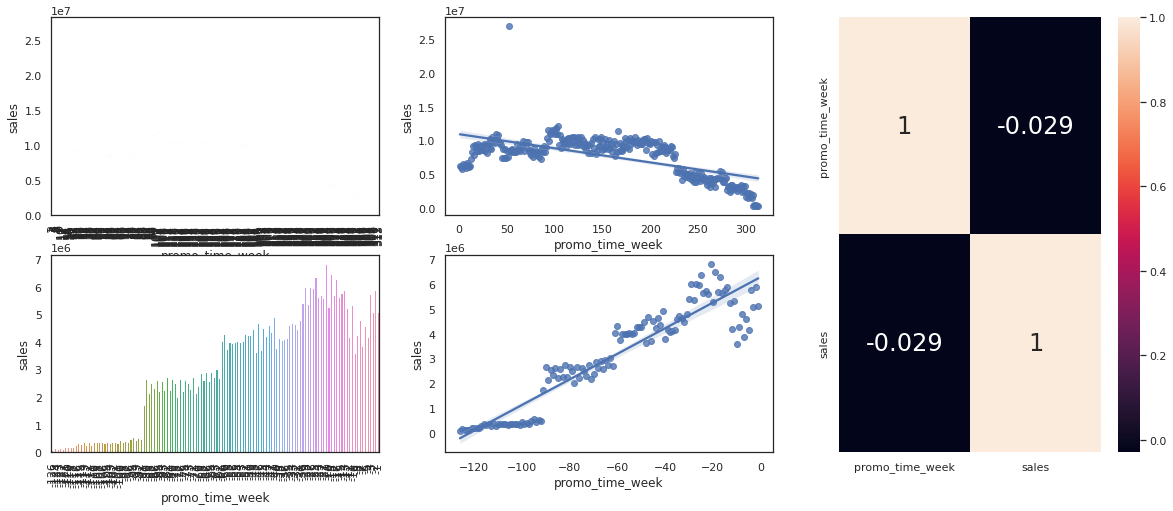

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.figure(figsize(20,8))

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotion
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

####**H6. Stores with more consecutive promotions should sell more.**
**False**: stores with more consecutive promotions sell less. There's no such an evidence of a strong relationship between this feature and the target.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


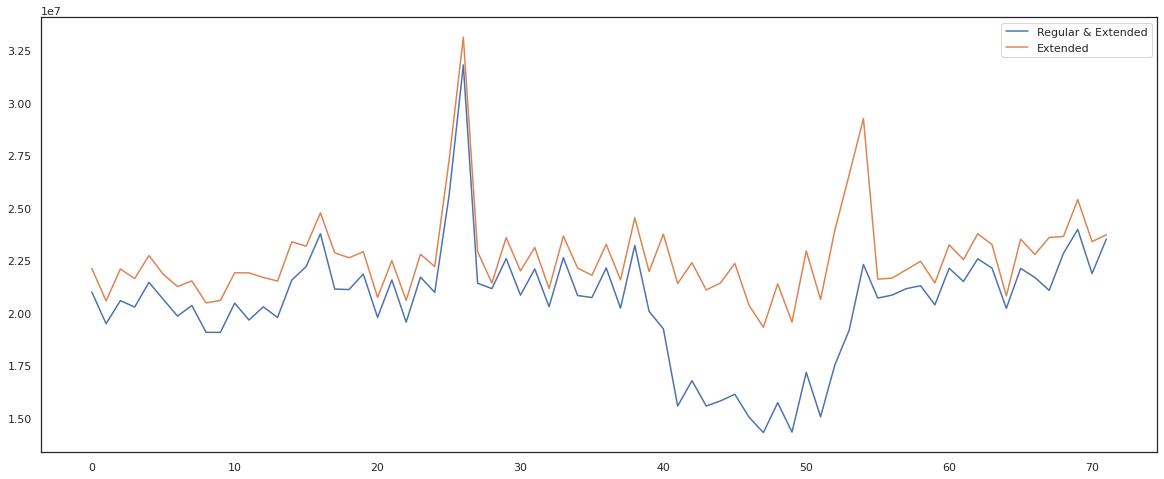

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular & Extended', 'Extended']);

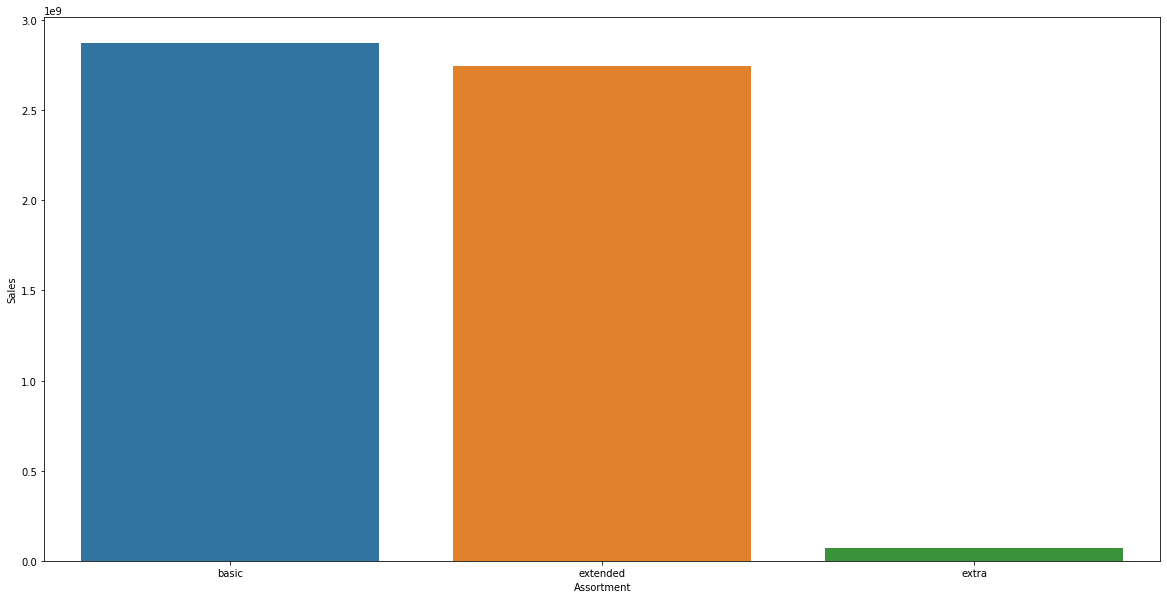

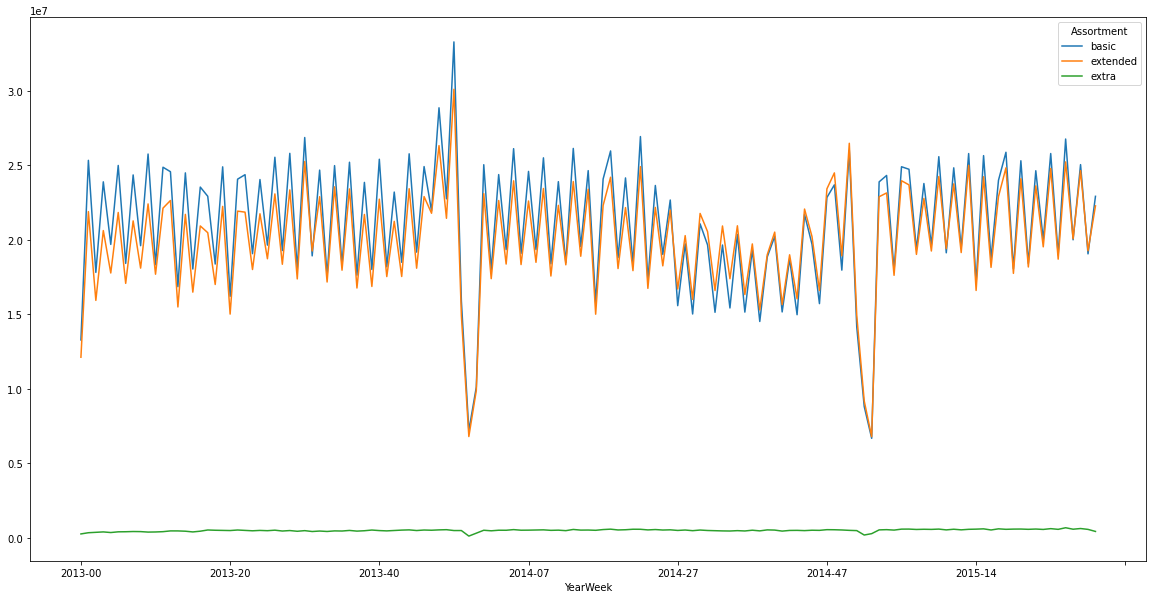

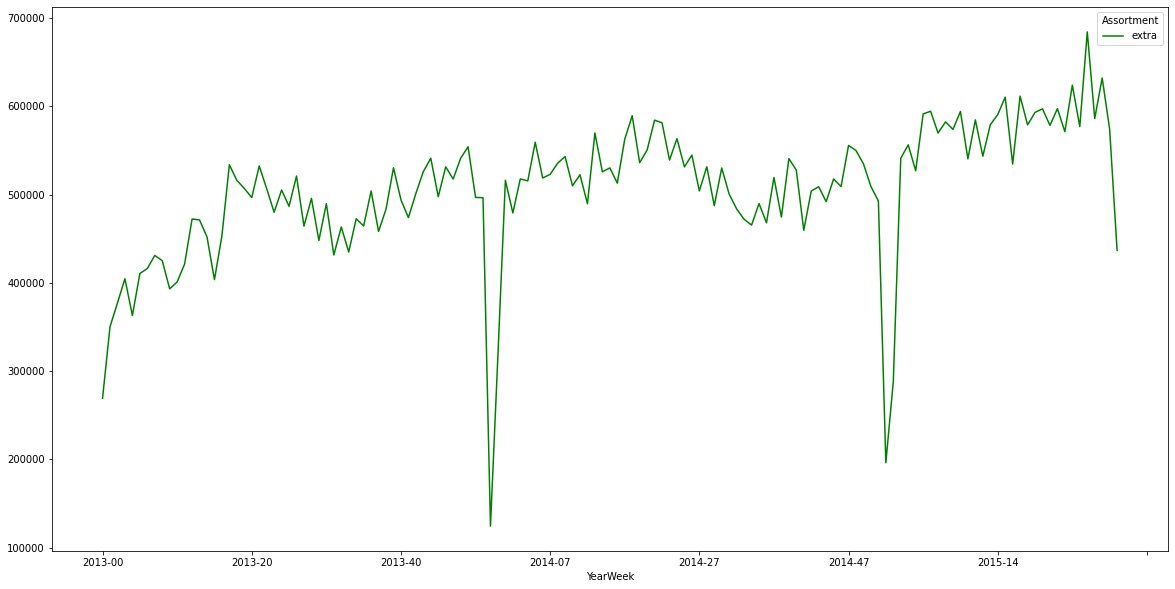

In [ ]:
test_1 = df[['Assortment', 'Sales']].groupby( 'Assortment' ).sum().reset_index()
plt.figure(figsize=(20,10))
sns.barplot( x='Assortment', y='Sales', data = test_1 )

test_2 = df[['YearWeek', 'Assortment', 'Sales']].groupby( ['YearWeek', 'Assortment'] ).sum().reset_index()

test_2.pivot( index='YearWeek', columns='Assortment', values='Sales' ).plot(figsize=(20,10))

test_3 = test_2[test_2['Assortment'] == 'extra']
test_3.pivot( index = 'YearWeek', columns = 'Assortment', values = 'Sales').plot( color = 'g',figsize=(20,10) );


####**H7. Stores open during the Christmas holiday should sell more.**
**False**: On average, Stores open during christmas have one of the highest sales amount, but easter holiday has a higher mean. In fact, stores sell more during holidays than during regular days. So, this feature can be considered important to the analysis

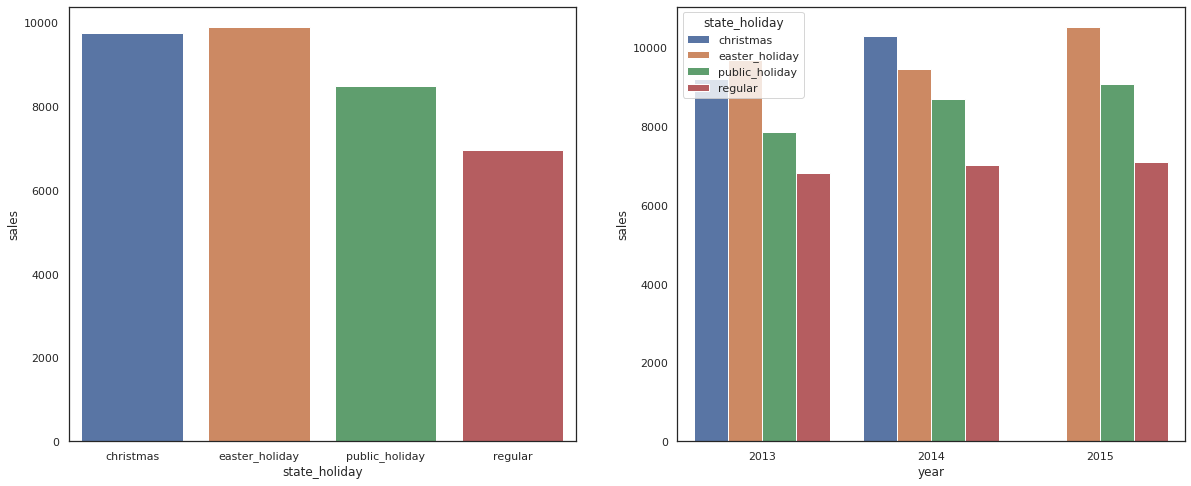

In [ ]:
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

####**H8. Stores should be selling more over the years.**
**True**: On average, sales are increasing over the year. Since the correlation is very high, this feature is important to the model.

Since 2015 is no completed yet, it's better to use mean instead of sum.

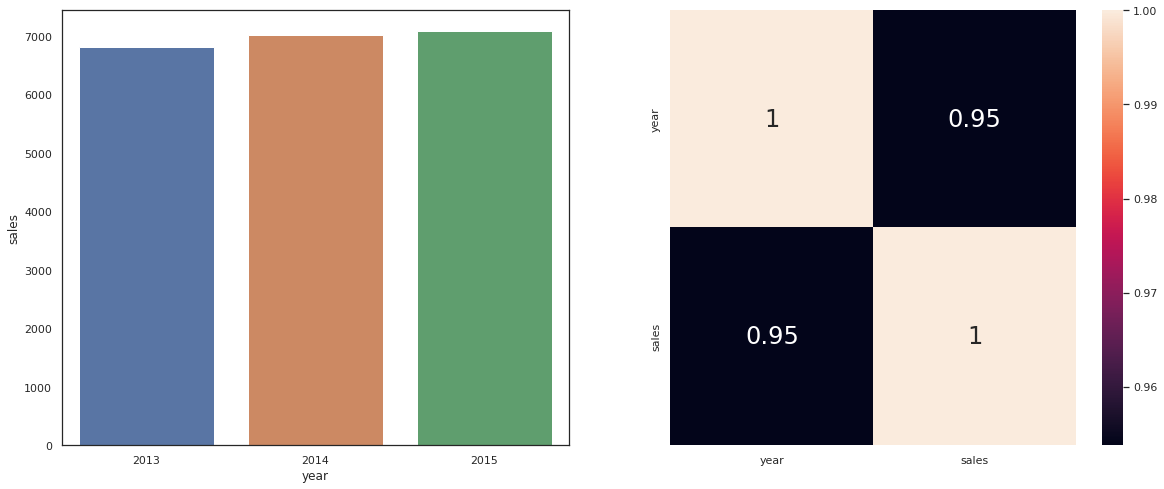

In [ ]:
aux1 = df4[['year', 'sales',]].groupby( 'year' ).mean().reset_index()

plt.subplot( 1, 2, 1)
sns.barplot( x='year', y='sales', data=aux1)

plt.subplot( 1, 2, 2)
sns.heatmap( aux1.corr(method = 'pearson'), annot=True);

####**H9. Stores should sell more in the second half of the year.**
**False**: Stores sell less in the second half of the year. The feature and the target have a moderate negative correlation and it can be considered important to the model.

Since 2015 is incomplete, I'll use mean instead of the sum to compare because the lack of data for the second half of the year will give us misinformation.

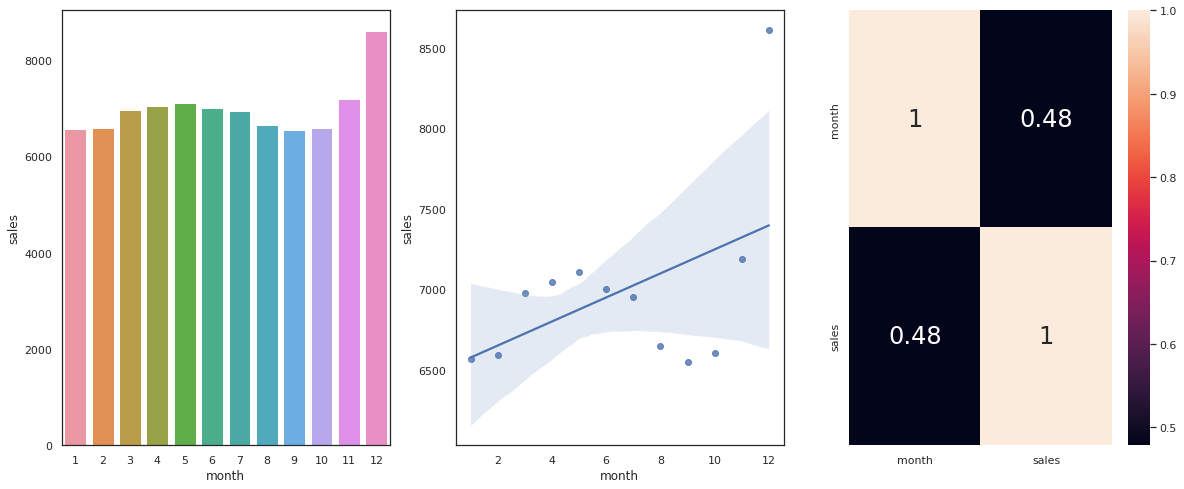

In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

####**H10. Stores should sell more after the 10th of each month.**
**False**: On average, there's no such a strong evidence that stores sell more after the 10th day of each month. In fact, the mean for this class is slightly smaller than for 'before_10_days'. The correlation between the feature and the target shows a relevant relationship. thus, It can be considered important to the model.

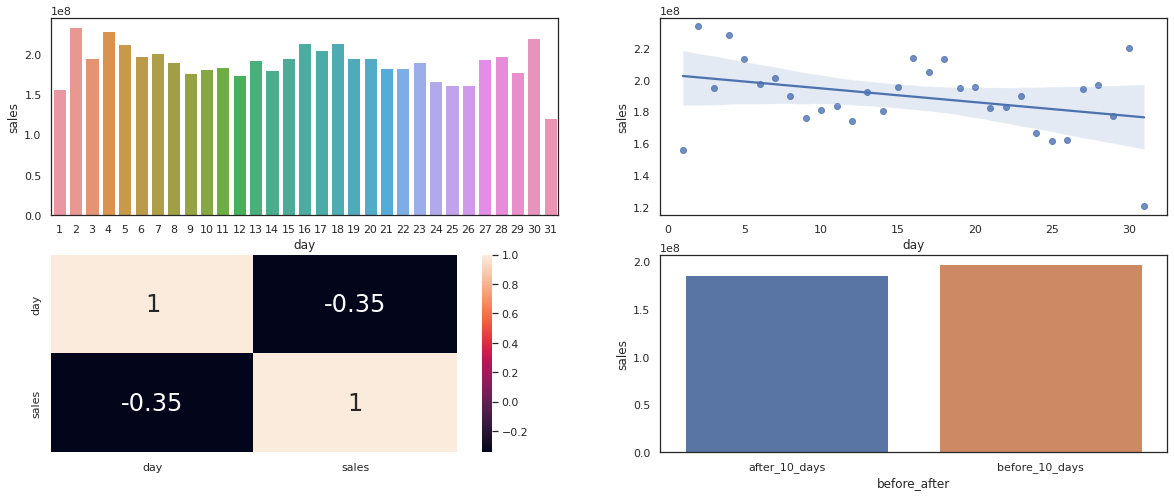

In [ ]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#creating a columns to analyse before and after the 10th day
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

####**H11. Stores should sell less on weekends.**
**False**: on average, I can't say that sales is lower on weekends. The correlation is strong enough to be considered in the model.

In [ ]:
df4['day_of_week'].value_counts()

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64

Since there's less sundays in the dataset, I'll use the mean to compare the sale by days.

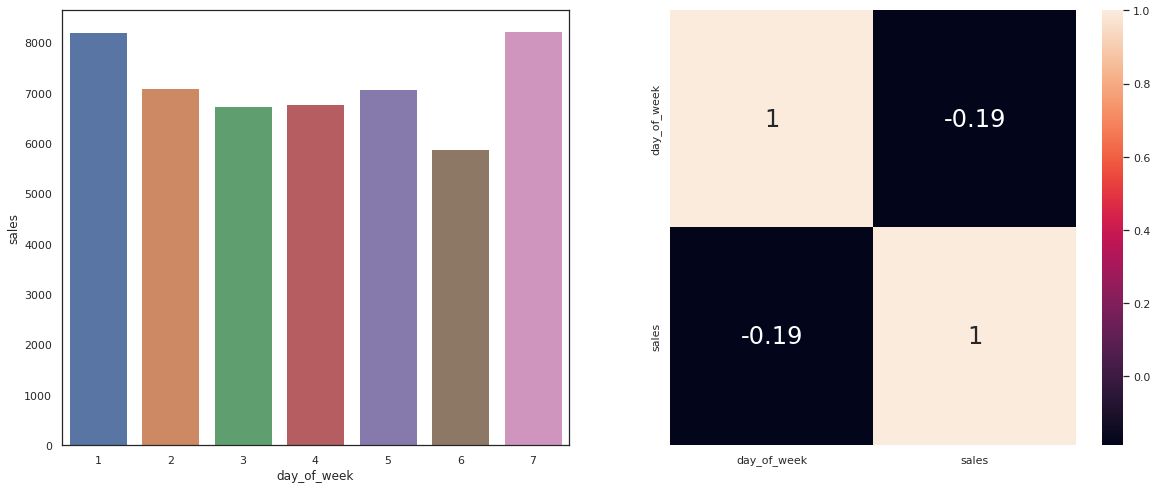

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

####**H12. Stores should sell less during school holidays.**
**False**: there's no such an evidence that stores sell less during school holidays. On average, it's almost the same.

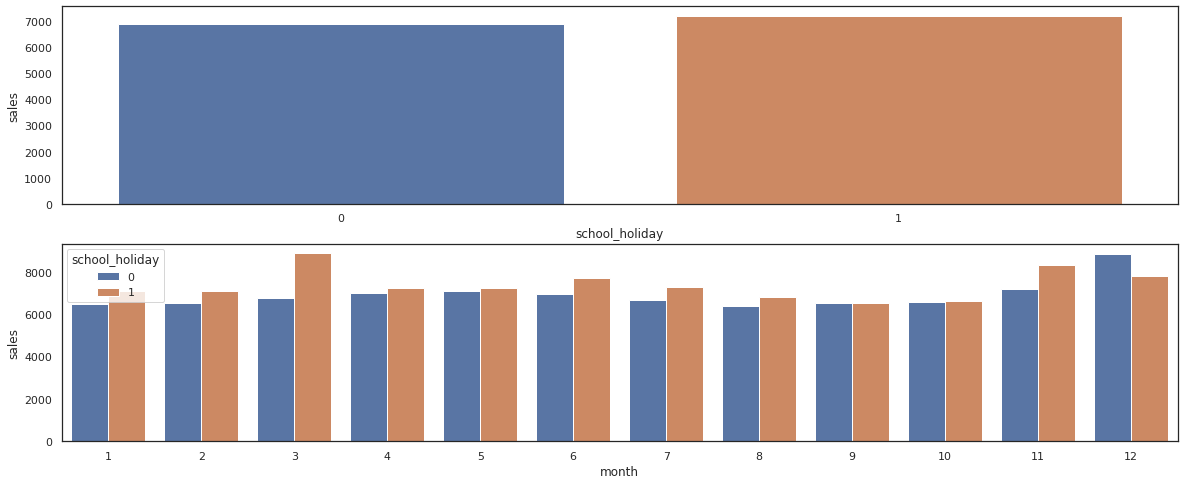

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

####**4.2.1. Hypothesis Validation Summary**

In [ ]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Medium'],  
      ['H2', 'False', 'Medium'],  
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'True', 'High'],
      ['H9', 'False', 'Medium'],
      ['H10', 'False', 'Medium'],
      ['H11', 'False', 'Medium'],
      ['H12', 'False', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Medium
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            True          High
H9            False         Medium
H10           False         Medium
H11           False         Medium
H12           False         Low


###**4.3. Multivariate Analysis**

####**4.3.1. Numerical Attributes**

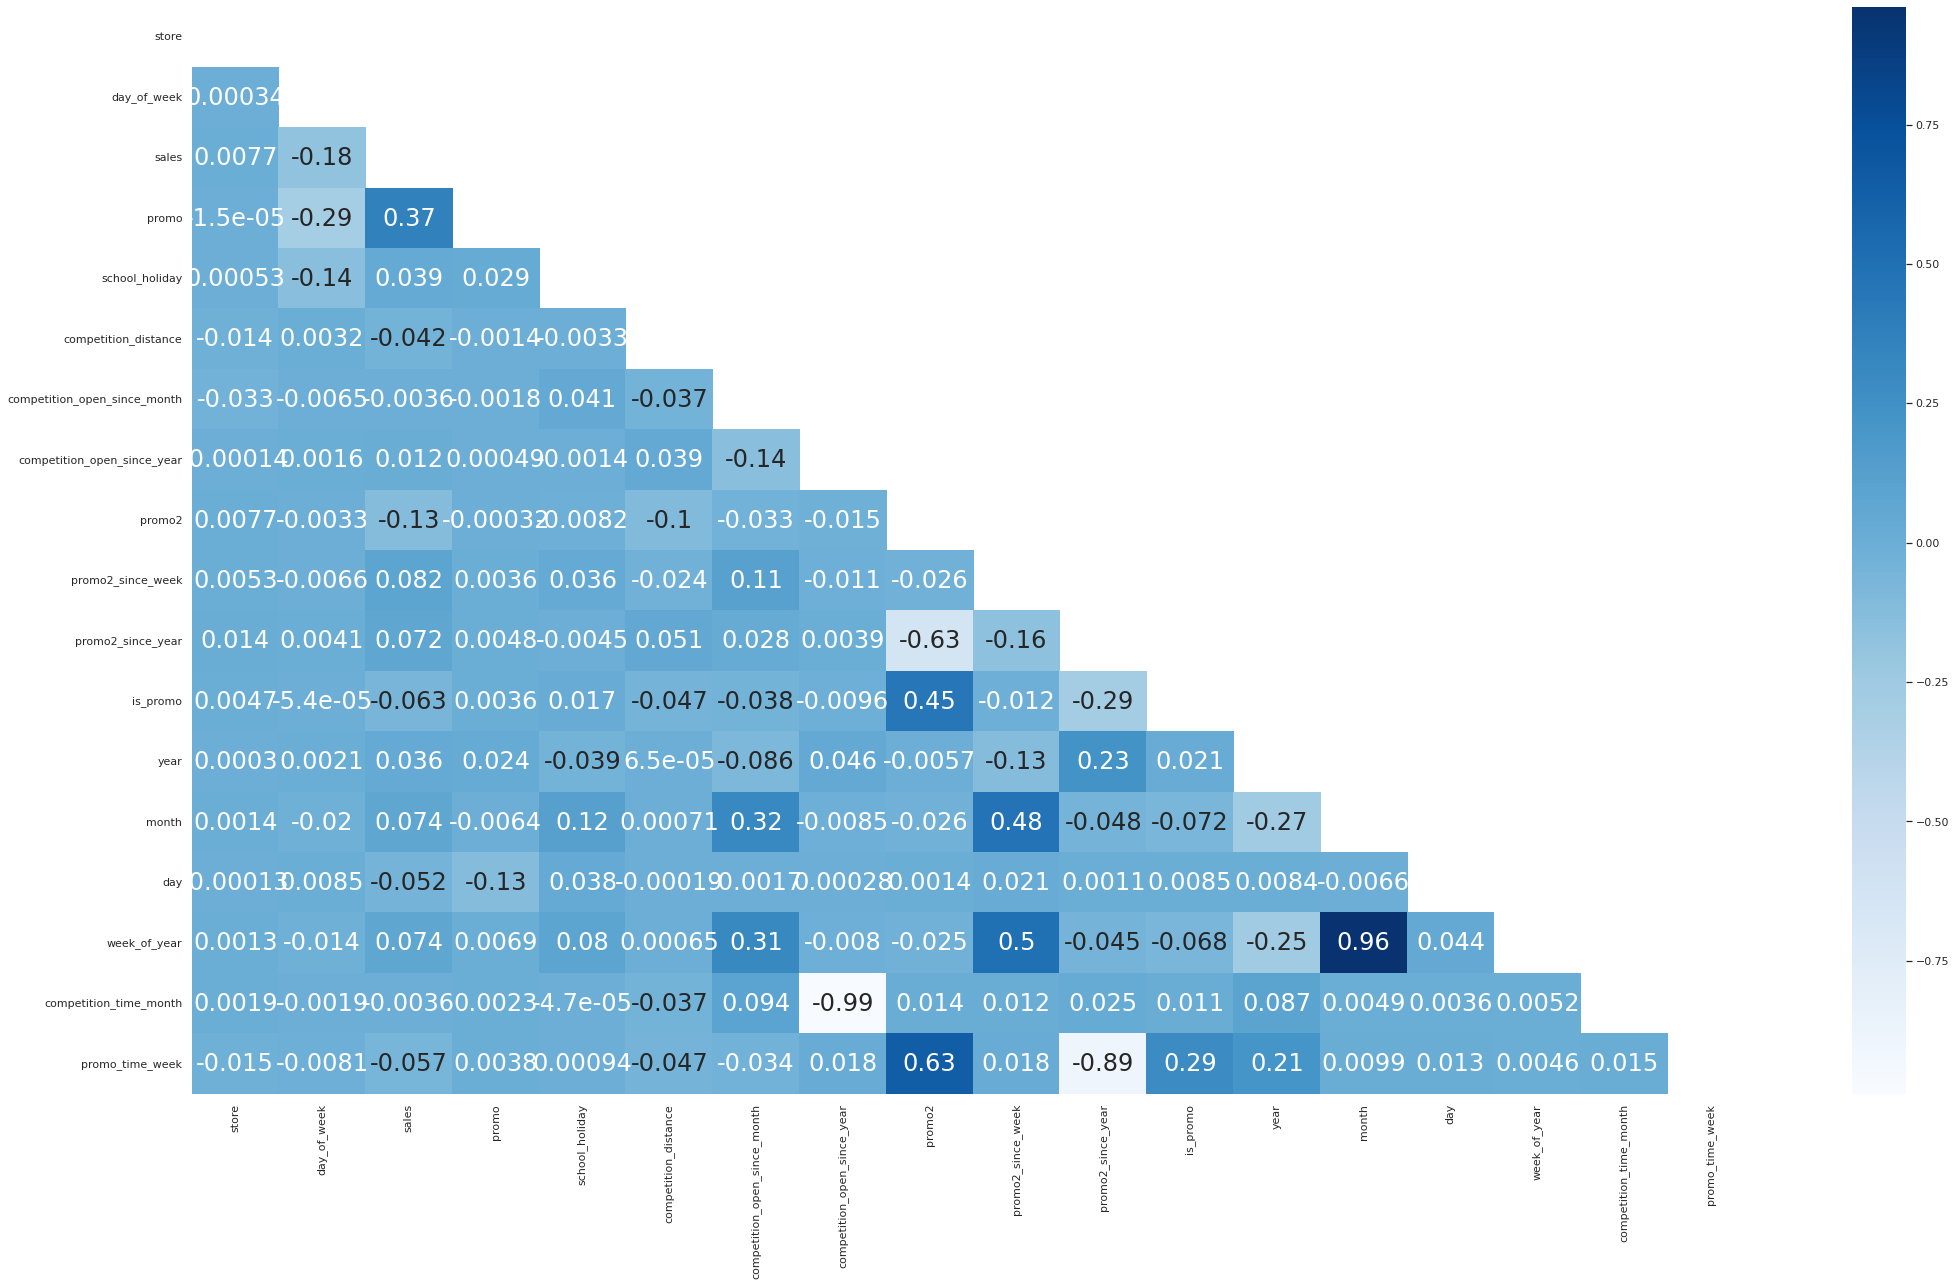

In [ ]:
mask = np.zeros_like( num_attributes.corr(), dtype=np.bool )
mask[np.triu_indices_from( mask )] = True
plt.subplots( figsize = ( 35,20 ) )
sns.heatmap( num_attributes.corr(), cmap='Blues', mask = mask, annot=True, center = 0 )
plt.show()

####**4.3.2. Categorical Attributes**
For categorical attributes I'm going to use Cramér's V test. Basically, it is a measure of association between two categorical variables and it returns a value between 0 and 1. Its formula is the following:



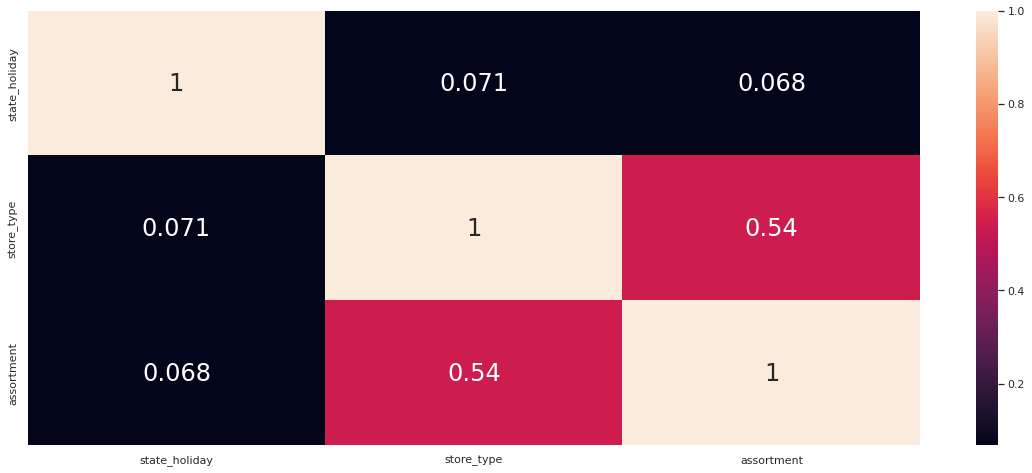

In [ ]:
# gettingonly categorical data
a = df4.select_dtypes( include='object' )

# Calculating cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

##**5.0. STEP 5: DATA PREPARATION**

In [ ]:
df5 = df4.copy()

###**5.1. Normalization**
Based on subsection 4.1.2, there's no evidence that the numerical variables have a normal distribution. So, I won't normalize any of them.

###**5.2. Rescaling**

In [ ]:
rs = RobustScaler()
miax = MinMaxScaler() 

# competition distance: there are relevant outliers, so, I'll use robust scaler
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# year
df5['year'] = miax.fit_transform( df5[['year']].values )


# competition time month: there are relevant outliers, so, I'll use robust scaler
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


# promo time week: even though there are less relevance of outliers, I'll use robust scaler
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )




###**5.3. Transforming**
####**5.3.1. Encoding**
For this first CRISP cycle, I'll use the following enconding techniques and if it doesn't perform well, I change it in the next cycle.

In [ ]:
# state holiday: one hot encoding
df5 = pd.get_dummies( df5, prefix=['school_holiday'], columns=['school_holiday'] )

# store type: label encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )


# assortment: ordinal encoding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

####**5.3.2. Response Variable Transformation**
ML algorithms need the response to be normal (or close to that). Thus, I'll perform a log transformation on the target variable.

In [ ]:
df5['sales'] = np.log1p( df5['sales'] )

####**5.3.3. Nature Transformation**
The goal here is to transform variables with a cyclic nature ( like day, week, month). To do that, I'll get the sin and cosin for each observation and make them new columns.

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) ) 
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

##**6.0. STEP 6: FEATURE SELECTION**





In this section it will be selected the relevant features to the model.

I'll use both Boruta and the business feeling (based on the experience from the Exploratory Data Analysis Section) to select the most relevant variables.

Boruta uses by defaul Random Forest to output the importance measure of a feature.

To do that, I'll ahve to:

1. split the dataframe into training and test datasets;
2. perform Boruta feature selector; and,
3. manually select features.


In [ ]:
df6 = df5.copy()

###**6.1. Split dataframe into training and test dataset**

In [ ]:
# droping columns that were used to create new features. Those columns won't be used in modeling.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19'] # from the first sale date to 2015-06-18 is the train dataset
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19'] # from this day on is the test dataset
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


###**6.2. Boruta as Feature Selector**
Since Boruta took too long to run on my local machine, I ran it on Colab and got the variables selected by the algorith.

In [ ]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 ) # ussing all machine cores to run faster

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

####**6.2.1. Best Features from Boruta**

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

###**6.3. Manual Feature Selection**
Based on the hypothesis validation in section 4 and the Boruta output, the following columns list is created: both selected and not selected.

Since I'm working in cycles, I can consider adding not selected variables in the future.

##**7.0. STEP 7 - MACHINE LEARNING MODELLING**

####**It's going to be build five models:**

1. **Average Model**
2. **Linear Regression Model**
3. **Linear Regression Regularized Model - Lasso**
4. **Random Forest Regressor**
5. **XGBoost Regressor**

The Average Model is going to be the baseline to compare if a model is better than the mean. After performing the Average Model, I'll perform two linear models (following the Occam's Razor of simplest model) and then I'll perform two non-linear models (in this case, two tree's based models).

To compare them it'll be used the Time Series Cross Validation (at the end of this section).

In [ ]:
df7 = df6.copy()

In [ ]:
# getting the selected cols from boruta to the train and test datasets
x_train = X_train[ cols_selected_boruta ]
x_test = X_test [ cols_selected_boruta]

###**7.1. Average Model**

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) # function created in section 0.1 (helper functions)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


###**7.2. Linear Regression Model**

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr )) # function created in section 0.1 (helper functions

lr_result



,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.65,0.29,2671.33


###**7.3. Linear Regression Regularized Model - Lasso**

In [ ]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Lasso Regression', np.expm1( y_test ), np.expm1( yhat_lrr )) # function created in section 0.1 (helper functions
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Lasso Regression,1891.46,0.29,2742.92


###**7.4. XGBoost Regressor**

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,856.03,0.12,1265.33


In [ ]:
print("Regresion Model Score" , ":" , model_xgb.score(x_test, y_test) )

Regresion Model Score : 0.8494899107687297


###**7.5. Random Forest Regressor**

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs= -1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf )) # function created in section 0.1 (helper functions
rf_result



,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.61,0.10,1005.68


In [ ]:
print("Regresion Model Score" , ":" , rf.score(x_test, y_test) )
      

Regresion Model Score : 0.9002094215858879


###**7.6. Comparing Model's Performance**

####**7.6.1. Single Performance**

In [ ]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.61,0.10,1005.68
0,XGBoost Regressor,856.03,0.12,1265.33
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.65,0.29,2671.33
0,Lasso Regression,1891.46,0.29,2742.92


####**Conclusions:**

1. The Linear Regression performed worse than the Average Model: the LR mean errors are greater than the average ones;

2. The data has a complex behavior (non-linear). Maybe, Linear Models can't learn its behavior;

3. Regularized Linear Regression performed even worse than Linear Regerssion Model.
4. Random Forest Regressor model got the smaller errors. However, it took too long to run (only with 100 estimators)

##**8.0. STEP 8: HYPERPARAMETER FINE TUNING**

####**8.1. Random Search**
Random Search works by iterations: it iterates over a value we choose and for, each iteration, it selects random values and tests the model with cross valdiation. At the end, it returns the combinations and the metrics.

This technique have some advantages and disadvantages:



*  **Advantages:** it is very quickly comparing to others and easy to perform;
*  **Disadvantages:** there's the possibility that it will never find thetrue best set of parameters because its search is randomly and the best set can not be in the interations chosen.




In [ ]:
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 10

In [ ]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
    
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
   
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

In [ ]:
#final_result

###**8.2. Final Model**

In [ ]:
# best parameters
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
    }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,644.21,0.10,933.16


In [ ]:
print("Regresion Model Score" , ":" , model_xgb_tuned.score(x_test, y_test) )

Regresion Model Score : 0.9095488227091855


##**9.1. Business Performance**

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

# rescaling
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

In [ ]:
# summing the prediction values by stores (so we can have the total sales predicted by stores)
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# calculating mean absolute error and mean absolute percentage error
df9_aux1 = df9[['sales', 'store', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'} )
df9_aux2 = df9[['sales', 'store', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'} )

# merging them
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# creating business scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordering columns

In [ ]:
# looking at the stores with high percentage error
df92.sort_values( 'MAPE', ascending = False).head( 8 )

,store,predictions,MAE,MAPE,worst_scenario,best_scenario
291,292,105383.86,3322.60,0.57,102061.26,108706.46
908,909,237669.67,7647.11,0.52,230022.56,245316.78
594,595,344569.97,4990.35,0.35,339579.62,349560.32
875,876,207206.31,3918.72,0.31,203287.59,211125.03
721,722,357292.44,2108.01,0.28,355184.43,359400.45
717,718,201979.52,1892.64,0.26,200086.88,203872.15
273,274,193574.20,1418.05,0.25,192156.15,194992.26
781,782,221717.41,750.29,0.23,220967.12,222467.70


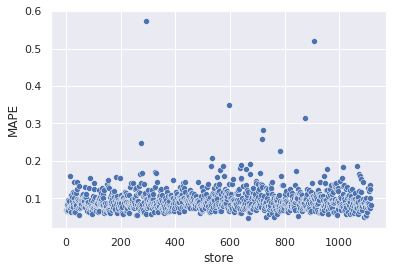

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

Some stores have a high error and they are more difficult to make accurately predictions. I'll try to handle in the next CRISP cycle. Depending on that error, the manager can better make decisions about the investment on each store and consider the best or the worst scenario.

###**9.1. Total Performance**
Providing the total sales predictions and the scenarios.

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 286,728,640.00"
1,worst_scenario,"R$ 286,006,481.14"
2,best_scenario,"R$ 287,450,811.48"


###**9.2. Machine Learning Performance**
I'm going to use some graphs to look at the model's performance.

In [ ]:
# creating the error and the error rate columns
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

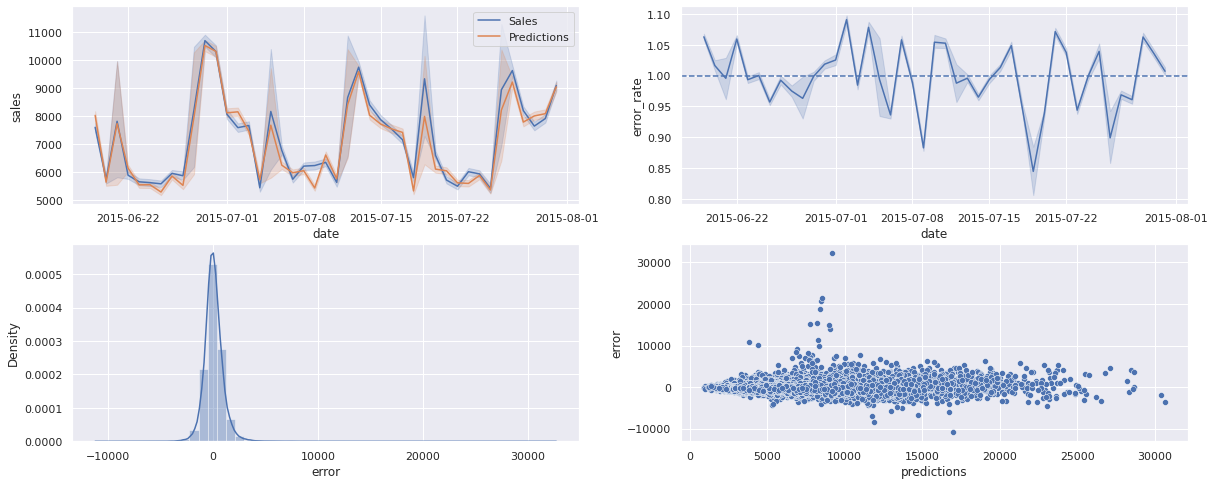

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--') # adding a horizontal line at zero

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );
plt.show()

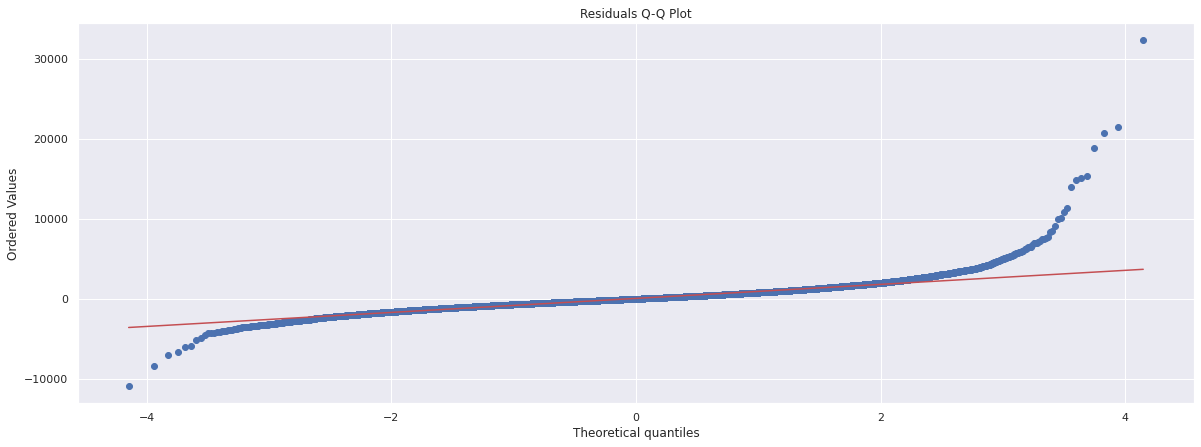

In [ ]:
# plotting a q-q chart
plt.figure(figsize=(20,7))
ss.probplot( df9['error'], dist = 'norm', plot = pylab )
plt.title( 'Residuals Q-Q Plot' );

####**Conclusions:**

1. **Business Performance:**
  * It was provided some metrics to help making decisions. Even though there are some stores with a high percentage error and there's no way to use them, the majority of them have a low error and can be used.
   * It was also provided the best and the worst sales amount scenarios to the end of the six weeks. With that, we reduced the uncertainty.
2. **Machine Learning Performance:**
 * The predictions seem to fit well on the real sales;
 * The residual's distribution seems to be close to Normal. It also seems to don't have any kind of heteroscedasticity. Since I am interested in deploy the model to production fast and create value to the company, I'll hadle with these adjustments in the next cycle of the project in order to improve the model.